In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [1]:
import os
from IPython import get_ipython
import pandas as pd
pd.set_option('float_format', '{:.2f}'.format)
import pandas_profiling as pp
import numpy as np
import scipy
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns
# Load models
from sklearn import ensemble, tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, recall_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA 

STORAGEACCOUNTNAME= os.environ.get('san')
STORAGEACCOUNTKEY= os.environ.get('sak')
CONTAINERNAME= os.environ.get('contname')
BLOBNAME= 'AirOnTime/2014_2012_AirOnTime.csv/AirOnTIme2004-2012.csv'
LOCALFILENAME= '2004_2012_AirOnTime.csv'

In [4]:
# Read CSV
df = pd.read_csv(
                LOCALFILENAME, 
                parse_dates=[4], 
                na_values=' ')

/home/ec2-user/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (21,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
# Drop unnecessary columns
df = df.drop(columns=[
    '_c44',
    'FL_DATE', # dates are hard to process in ML models 
    'ORIGIN_STATE_ABR', # needs one_hot_encoding -> too inefficient 
    'DEST_STATE_ABR', # needs one_hot_encoding -> too inefficient
    'NAS_DELAY', # too much sematic regarding ARR_DELAY (the Y)
    'SECURITY_DELAY', # too much sematic regarding ARR_DELAY (the Y)
    'LATE_AIRCRAFT_DELAY', # too much sematic regarding ARR_DELAY (the Y)
    'WEATHER_DELAY', # too much sematic regarding ARR_DELAY (the Y)
    'CARRIER_DELAY', # too much sematic regarding ARR_DELAY (the Y)
    'FLIGHTS', # only values of 1
    'ARR_TIME', # too much sematic regarding ARR_DELAY (the Y)
    'ARR_DELAY_GROUP', # too much sematic regarding ARR_DELAY (the Y)
    'ARR_DEL15', # too much sematic regarding ARR_DELAY (the Y) and boolean
    'ACTUAL_ELAPSED_TIME', # too much sematic regarding ARR_DELAY (the Y) and boolean
    'ARR_DELAY', # has negative numbers but we are only interested in flights with a delay of > 30min
    'CANCELLATION_CODE' # too many missing values and no contribution to Y (assumption)
])
# Drop ca. 2% of rows which have a lot of missing values
df = df.dropna(subset=['DEP_DEL15'])
# Convert to numeric 
df['WHEELS_OFF'] = pd.to_numeric(df['WHEELS_OFF'], errors='coerce')
df = df.dropna(subset=['WHEELS_OFF'])
# Fill all NaNs with 0
df.fillna(0)
# Define the Y
df['y_delayed'] = np.where(df['ARR_DELAY_NEW'] > 30.0 , 1, 0)
df = df.drop(columns=['ARR_DELAY_NEW'])
# Clean more NaN
df = df.dropna() # (144'734 rows)
# Sample for higher iteration
df_all = df
df = df.sample(5000000, random_state=1232)

In [9]:
# Do second data profile report on cleaned data
pp.ProfileReport(df, check_correlation=False, pool_size=15).to_file(outputfile="AirlineOnTime_CLEAN.html")
# See the webpage at: 

/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: Us

In [10]:
# Correlation
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=10):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df.drop(columns=['DEST', 'ORIGIN', 'UNIQUE_CARRIER', 'TAIL_NUM']), 50).to_string())

Top Absolute Correlations
DEP_DELAY         DEP_DELAY_NEW      0.99
CRS_ELAPSED_TIME  AIR_TIME           0.99
DISTANCE          DISTANCE_GROUP     0.99
AIR_TIME          DISTANCE           0.98
CRS_ELAPSED_TIME  DISTANCE           0.98
DEP_TIME          WHEELS_OFF         0.98
CRS_ELAPSED_TIME  DISTANCE_GROUP     0.97
AIR_TIME          DISTANCE_GROUP     0.97
CRS_DEP_TIME      DEP_TIME           0.97
                  WHEELS_OFF         0.95
DEP_DELAY         DEP_DELAY_GROUP    0.94
DEP_DELAY_NEW     DEP_DELAY_GROUP    0.93
WHEELS_ON         CRS_ARR_TIME       0.89
WHEELS_OFF        CRS_ARR_TIME       0.80
DEP_TIME          CRS_ARR_TIME       0.79
CRS_DEP_TIME      CRS_ARR_TIME       0.79
WHEELS_OFF        WHEELS_ON          0.76
DEP_DEL15         DEP_DELAY_GROUP    0.75
DEP_TIME          WHEELS_ON          0.74
DEP_DELAY_GROUP   y_delayed          0.74
CRS_DEP_TIME      WHEELS_ON          0.73
DEP_DELAY         y_delayed          0.69
DEP_DELAY_NEW     y_delayed          0.68
DEP_DELA

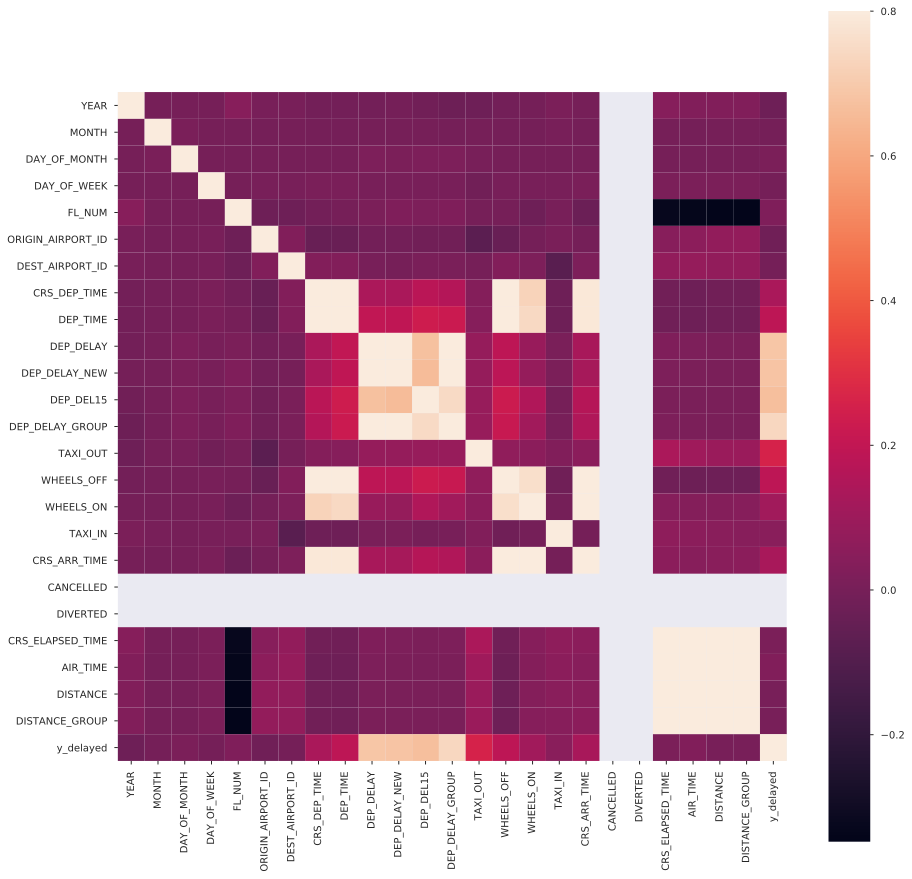

In [11]:
# Plot a heatmap to see all correlations between vars
plt.figure(figsize = (15,15))
sns_plot = sns.heatmap(df.corr(), vmax=.8, square=True)
sns_plot.get_figure().savefig('heatmap.png', bbox_inches='tight', dpi=200) 
sns_plot.get_figure().show()

 #### Findings
 1. Correlation to y (delayed) exists:
 2. Multicollinearity is in general low, but certain variables are highly correlated
   * like DEP_xxxx vars
   * DISTANCE - DISTANCE_GROUP - AIR_TIME
 3. Class imbalance: 17601697 - 2398303 (88%/12%)

 #### Models to try:
 1. LogisticRegression
 2. Descion Tree
 3. Naive Bayes
 4. RandomForestClassifier
 5. KNN
 6. Support Vector Machine
 7. GradientBoostingClassifier
 8. (Also use of KSelectBest, GridSearch)

In [13]:
#Class Balancing via Under-Sampling
count_class_0, count_class_1 = df.y_delayed.value_counts()

# Divide by class
df_class_0 = df[df['y_delayed'] == 0]
df_class_1 = df[df['y_delayed'] == 1]
print('Random under-sampling:')
df_class_0_under = df_class_0.sample(count_class_1)
df = pd.concat([df_class_0_under, df_class_1], axis=0)
print(df.y_delayed.value_counts())

# Normalize
mm_scaler = MinMaxScaler()
df[['YEAR']] = mm_scaler.fit_transform(df[['YEAR']].values) # Cyclical Features
df[['MONTH']] = mm_scaler.fit_transform(df[['MONTH']].values) # Cyclical Features
df[['DAY_OF_MONTH']] = mm_scaler.fit_transform(df[['DAY_OF_MONTH']].values) # Cyclical Features
df[['DAY_OF_WEEK']] = mm_scaler.fit_transform(df[['DAY_OF_WEEK']].values) # Cyclical Features
df[['FL_NUM']] = mm_scaler.fit_transform(df[['FL_NUM']].values)
df[['ORIGIN_AIRPORT_ID']] = mm_scaler.fit_transform(df[['ORIGIN_AIRPORT_ID']].values)
df[['DEST_AIRPORT_ID']] = mm_scaler.fit_transform(df[['DEST_AIRPORT_ID']].values)
df[['CRS_DEP_TIME']] = mm_scaler.fit_transform(df[['CRS_DEP_TIME']].values)
df[['DEP_TIME']] = mm_scaler.fit_transform(df[['DEP_TIME']].values)
df[['DEP_DELAY']] = mm_scaler.fit_transform(df[['DEP_DELAY']].values)
df[['DEP_DELAY_NEW']] = mm_scaler.fit_transform(df[['DEP_DELAY_NEW']].values)
df[['DEP_DEL15']] = mm_scaler.fit_transform(df[['DEP_DEL15']].values)
df[['DEP_DELAY_GROUP']] = mm_scaler.fit_transform(df[['DEP_DELAY_GROUP']].values)
df[['TAXI_OUT']] = mm_scaler.fit_transform(df[['TAXI_OUT']].values)
df[['WHEELS_OFF']] = mm_scaler.fit_transform(df[['WHEELS_OFF']].values)
df[['WHEELS_ON']] = mm_scaler.fit_transform(df[['WHEELS_ON']].values)
df[['TAXI_IN']] = mm_scaler.fit_transform(df[['TAXI_IN']].values)
df[['CRS_ARR_TIME']] = mm_scaler.fit_transform(df[['CRS_ARR_TIME']].values)
df[['CANCELLED']] = mm_scaler.fit_transform(df[['CANCELLED']].values)
df[['DIVERTED']] = mm_scaler.fit_transform(df[['DIVERTED']].values)
df[['CRS_ELAPSED_TIME']] = mm_scaler.fit_transform(df[['CRS_ELAPSED_TIME']].values)
df[['AIR_TIME']] = mm_scaler.fit_transform(df[['AIR_TIME']].values)
df[['DISTANCE']] = mm_scaler.fit_transform(df[['DISTANCE']].values)
df[['DISTANCE_GROUP']] = mm_scaler.fit_transform(df[['DISTANCE_GROUP']].values)
df[['y_delayed']] = mm_scaler.fit_transform(df[['y_delayed']].values)

Random under-sampling:
1    596314
0    596314
Name: y_delayed, dtype: int64


/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [14]:
# Define X and y
X = df.drop(columns=['y_delayed',
                     'ORIGIN',
                     'DEST',
                     'TAIL_NUM',
                     'FL_NUM',
                     'UNIQUE_CARRIER'
                    ])
X = pd.concat([X, pd.get_dummies(df['DEST'])], axis=1)
X = pd.concat([X, pd.get_dummies(df['ORIGIN'])], axis=1)
# X = pd.concat([X, pd.get_dummies(df['UNIQUE_CARRIER'])], axis=1)

y = df['y_delayed']

#Try SelectKBest
X_selKBest = SelectKBest(k=100).fit_transform(X, y)

# Use PCA (but it is not working better)
# sklearn_pca = PCA(n_components=100)
# X_pca = sklearn_pca.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_selKBest, y, test_size=0.2, random_state=20)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [17 18] are constant.
  UserWarning)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [15]:
# Logistic Regression: 
lr = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=50, verbose=1, n_jobs=10)

# Fit the model.
fit = lr.fit(X_train, y_train)

# Display.
y_pred = fit.predict(X_test)
print('Confusion Matrix\n', pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print('LG:\n', classification_report(y_test, y_pred, target_names=['0', '1']))
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
print('\nAUC: ', auc(fpr, tpr))
"""
Without Under-Sampling:
               precision    recall  f1-score   support
           0       0.97      0.99      0.98   3524444
           1       0.89      0.78      0.83    475556
Under-Sampling:
           0       0.93      0.96      0.94    476270
           1       0.96      0.93      0.94    475768
SelectKBest=100
           0       0.93      0.95      0.94    119663
           1       0.95      0.92      0.94    118863
"""
score = cross_val_score(fit, X, y, cv=5, scoring='recall', n_jobs=10)
print('\nRecall: ', score)
print("Cross Validated Recall: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
# Cross Validated Recall: 0.93 (+/- 0.01)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  1.3min finished


Confusion Matrix
 Predicted     0.0     1.0     All
True                             
0.0        113255    6408  119663
1.0          7269  111594  118863
All        120524  118002  238526


LG:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94    119663
           1       0.95      0.94      0.94    118863

   micro avg       0.94      0.94      0.94    238526
   macro avg       0.94      0.94      0.94    238526
weighted avg       0.94      0.94      0.94    238526


AUC:  0.9426475871796529



Recall:  [0.93326514 0.92876248 0.93610759 0.92495577 0.92563432]
Cross Validated Recall: 0.93 (+/- 0.01)


In [16]:
#Run best DT model:

dt = tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=8,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

# Fit the best algorithm to the data. 
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=8,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [17]:
# Evaluate
y_pred = dt.predict(X_test)
print('Confusion Matrix\n', pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print('DT:\n', classification_report(y_test, y_pred, target_names=['0', '1']))
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
print('AUC: ', auc(fpr, tpr))
"""
Without Under-Sampling:
               precision    recall  f1-score   support
           0       0.98      0.99      0.98     88009
           1       0.89      0.82      0.85     11991
Under-Sampling:
           0       0.85      0.95      0.90    476270
           1       0.94      0.84      0.89    475768
SelectKBest=100
           0       0.80      0.93      0.86    119663
           1       0.91      0.77      0.83    118863
"""
score = cross_val_score(dt, X, y, cv=10, scoring='recall', n_jobs=-1, verbose=1)
print("DT: Input X --> Recall: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))
# DT: Input X --> Recall: 0.810 (+/- 0.029)

Confusion Matrix
 Predicted    0.0     1.0     All
True                            
0.0        75906   43757  119663
1.0         9938  108925  118863
All        85844  152682  238526
DT:
               precision    recall  f1-score   support

           0       0.88      0.63      0.74    119663
           1       0.71      0.92      0.80    118863

   micro avg       0.77      0.77      0.77    238526
   macro avg       0.80      0.78      0.77    238526
weighted avg       0.80      0.77      0.77    238526

AUC:  0.7753612767167093
DT: Input X --> Recall: 0.533 (+/- 0.711)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:   13.9s remaining:   55.5s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   14.9s finished


In [18]:
# Naive Bayes:
bnb = BernoulliNB()
# Fit our model to the data.
bnb.fit(X_train, y_train)

# Evaluate
y_pred = bnb.predict(X_test)
print('Confusion Matrix\n', pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print('BNB:\n', classification_report(y_test, y_pred, target_names=['0', '1']))
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
print('AUC: ', auc(fpr, tpr))
"""
Without Under-Sampling:
               precision    recall  f1-score   support
           0       0.98      0.91      0.95   3524444
           1       0.57      0.89      0.70    475556
Under-Sampling:
           0       0.89      0.91      0.90    476270
           1       0.91      0.89      0.90    475768
SelectKBest=100
           0       0.89      0.91      0.90    119663
           1       0.91      0.89      0.90    118863
"""
score = cross_val_score(bnb, X, y, cv=10, scoring='recall', n_jobs=-1, verbose=1)
print("BNB: Input X --> Recall: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))
#BNB: Input X --> Recall: 0.888 (+/- 0.001)

Confusion Matrix
 Predicted     0.0     1.0     All
True                             
0.0        108842   10821  119663
1.0         13218  105645  118863
All        122060  116466  238526
BNB:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90    119663
           1       0.91      0.89      0.90    118863

   micro avg       0.90      0.90      0.90    238526
   macro avg       0.90      0.90      0.90    238526
weighted avg       0.90      0.90      0.90    238526

AUC:  0.899183695362384
BNB: Input X --> Recall: 0.889 (+/- 0.002)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:   31.5s remaining:  2.1min


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   34.2s finished


In [19]:
# Run best model:
rfc = ensemble.RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=13, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=32, n_jobs=17,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Fit the best algorithm to the data. 
rfc.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=13, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=32, n_jobs=17,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [20]:
y_pred = rfc.predict(X_test)
print('Confusion Matrix\n', pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print('RFC:\n', classification_report(y_test, y_pred, target_names=['0', '1']))
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
print('AUC: ', auc(fpr, tpr))
'''
Without Under-Sampling:
              precision    recall  f1-score   support
           0       0.98      0.99      0.99    176169
           1       0.95      0.85      0.90     23831
Under-Sampling:
           0       0.89      0.94      0.91    476270
           1       0.93      0.89      0.91    475768
SelectKBest=100
           0       0.94      0.95      0.95    119663
           1       0.95      0.94      0.95    118863
'''
score = cross_val_score(rfc, X, y, cv=10, scoring='recall', n_jobs=-1, verbose=1)
print("RFC: Input X --> Recall: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))


Confusion Matrix
 Predicted     0.0     1.0     All
True                             
0.0        113751    5912  119663
1.0          6673  112190  118863
All        120424  118102  238526
RFC:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95    119663
           1       0.95      0.94      0.95    118863

   micro avg       0.95      0.95      0.95    238526
   macro avg       0.95      0.95      0.95    238526
weighted avg       0.95      0.95      0.95    238526

AUC:  0.9472271620724241
RFC: Input X --> Recall: 0.884 (+/- 0.017)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:  1.9min remaining:  7.7min


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.9min finished


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=20)
# Gradient Boosting
# We'll make 100 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 100,
          'max_depth': 2,
          'loss': 'deviance',
          'verbose': 1,
          'n_iter_no_change': 50, 
          'validation_fraction': 0.1,
          'learning_rate': 0.5
          }

# Initialize and fit the model.
gbc = ensemble.GradientBoostingClassifier(**params)
gbc.fit(X_train, y_train)

y_pred = gbc.predict(X_test)
print('Confusion Matrix\n', pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print('GradBoost:\n', classification_report(y_test, y_pred, target_names=['0', '1']))
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
print('AUC: ', auc(fpr, tpr))
# Best:
'''
Without Under-Sampling:
               precision    recall  f1-score   support
           0       0.99      0.99      0.99     88009
           1       0.96      0.91      0.93     11991
Under-Sampling
           0       0.95      0.95      0.95     24938
           1       0.95      0.95      0.95     25041
SelectKBest=100
           0       0.99      0.97      0.98     10011
           1       0.97      0.99      0.98      9989
'''
score = cross_val_score(gbc, X, y, cv=10, scoring='recall', n_jobs=-1, verbose=1)
print("GradBoost: Input X --> Recall: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))
"""
GradBoost: Input X --> Recall: 0.987 (+/- 0.004) - elapsed: 12.4min
"""


      Iter       Train Loss   Remaining Time 
         1           0.8050           56.66m
         2           0.5879           56.17m
         3           0.4833           55.74m
         4           0.4292           55.10m
         5           0.3810           54.44m
         6           0.3606           53.83m
         7           0.3445           53.67m


 #### Models to try:
 1. LogisticRegression
 2. Descion Tree
 3. Naive Bayes
 4. RandomForestClassifier
 5. KNN
 6. Support Vector Machine
 7. GradientBoostingClassifier

In [12]:
  
# Also use of KSelectBest, GridSearch

 #### Final model evaluation:
 The best model in all approaches is gradient boosting.
 Approaches are:
 * Without Under-Sampling --> 0.99/0.91 recall
 * Under-Sampling --> 0.95/0.95 recall
 * SelectKBest=100 --> 0.97/0.99 recall
 Every new approach boost the model performance, with SelectKBest winning in this case.
 Other models could not cope with under-sampling or SelectKBest strategies as shown with gradient boosting.
 Looks like boosting really helps to learn the more difficult cases as well.
 And that with no overfitting. The variance of the cross validation score is tiny.
### Other models
 * SVM cannot handle that much data. The performance is therefore quite poor.
 * KNN has a similar problem. It gets harder for KNN to process a lot of data.
 * RandomForest is the second best model. Specially with SelectKBest --> 0.95/0.94 recall
 * Decision tree could not improve much with under-sampling and got worse with SelectKBest
 * Naive Bayes is really fast to compute and results are quite good: SelectKBest --> 0.91/0.89 recall
 * Logistic Regression get very inefficient with a lot of data. The results are very good: Under-sampling --> 0.96/0.93 recall